<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>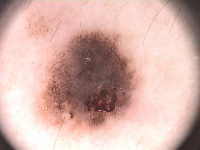</td><td>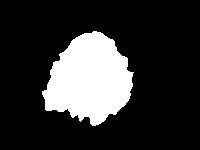</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-09-14 16:59:56--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-09-14 16:59:56--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc93832900fcbbef7750b44b97c0.dl.dropboxusercontent.com/cd/0/inline/CDvClCY61MP-zmJxyOlDnutu7KsWeJ4SMlnGnFZYZd6PL6WhUTQaa1hxpGMKIfEt5r_tzrZ3M1Uu955A3GtIak9Ps8AokY_F4e2gouY6NAL6fsSbf6uf31qj27NJoKfeswU/file# [following]
--2023-09-14 16:59:57--  https://uc93832900fcbbef7750b44b97c0.dl.dropboxusercontent.com/cd/0/inline/CDvClCY61MP-zmJxyOlDnutu7KsWeJ4SMlnGnFZYZd6PL6WhUTQaa1hxpGMKIfEt5r_tzrZ3M1Uu955A3GtIak9Ps8AokY_F4e2gouY6NAL6fsSbf6uf3

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
import imageio
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
import numpy as np
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

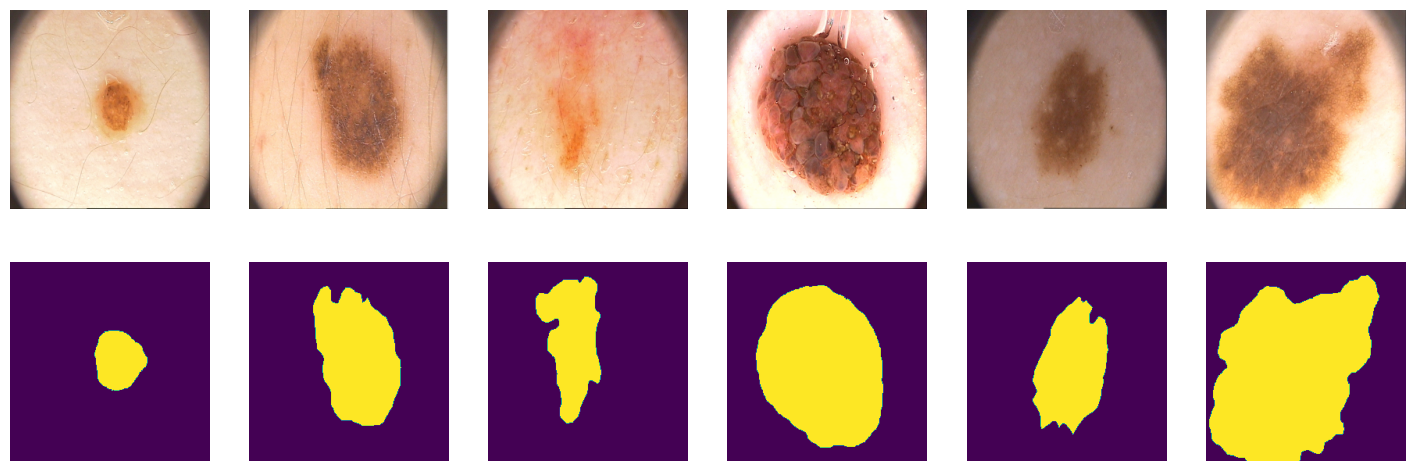

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset

batch_size = 25
train_loader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), shuffle=True)
test_loader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])), shuffle=True)

combined_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])
train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

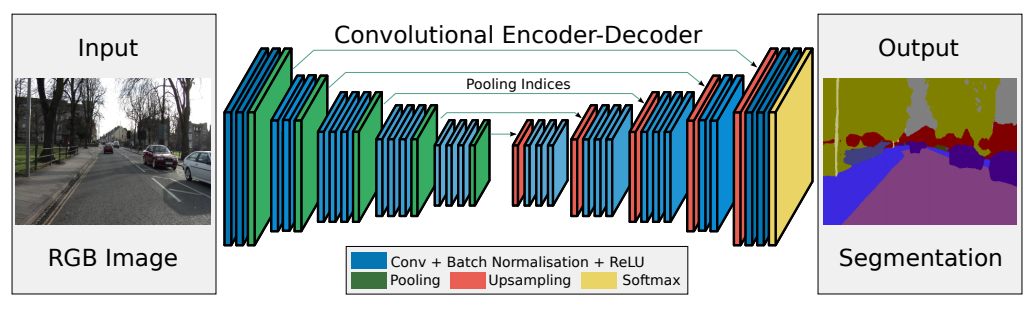

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # 64x128x128
        self.encoder_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        # 128x64x64
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        # 256x32x32
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        # 512x16x16
        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        # 512x8x8
        self.encoder_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )


        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # 512x16x16
        self.decoder_5 = nn.Sequential(
            # nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # 256x32x32
        self.decoder_4 = nn.Sequential(
            # nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        # 128x64x64
        self.decoder_3 = nn.Sequential(
            # nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        # 64x128x128
        self.decoder_2 = nn.Sequential(
            # nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # 1x256x256
        self.decoder_1 = nn.Sequential(
            # nn.MaxUnpool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )


    def forward(self, x):
        x, indices_1 = self.encoder_1(x)
        x, indices_2 = self.encoder_2(x)
        x, indices_3 = self.encoder_3(x)
        x, indices_4 = self.encoder_4(x)
        x, indices_5 = self.encoder_5(x)

        x = self.decoder_5(self.unpool(x, indices_5))
        x = self.decoder_4(self.unpool(x, indices_4))
        x = self.decoder_3(self.unpool(x, indices_3))
        x = self.decoder_2(self.unpool(x, indices_2))
        x = self.decoder_1(self.unpool(x, indices_1))
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

0.7604513764381409


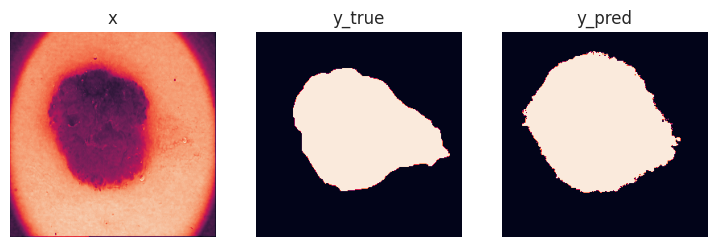

In [ ]:
image = 0
for x, y in test_loader:
    image_x = x[0][0]
    image_y_true = y[0][0]
    x, y = x.to(device), y.to(device)
    output = model(x)
    logit = torch.sigmoid(output)[0][0]
    threshold = 0.5
    logit = (logit >= threshold).float()
    image_y_pred = logit
    iou = IOU(output, y)
    print(iou)
    break

fig, ax = plt.subplots(ncols=3, figsize=(9, 3))

image_x = image_x.numpy()
image_y_true = image_y_true.numpy()
image_y_pred = image_y_pred.cpu().detach().numpy()

ax[0].imshow(image_x)
ax[0].set_title('x')

ax[1].imshow(image_y_true)
ax[1].set_title('y_true')

ax[2].imshow(image_y_pred)
ax[2].set_title('y_pred')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def predict(model, data):
    model.eval()
    with torch.no_grad():
        Y_pred = [ X_batch for X_batch, _ in data]
        return np.array(Y_pred)

def score_model(model, metric, data):
    model.eval()
    with torch.no_grad():
        scores = 0
        for x, y in data:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            scores += metric(y_pred, y).mean().item()
    return scores/len(data)

def IOU(output: torch.Tensor, y_true: torch.Tensor):
    logit = torch.sigmoid(output)
    y_pred = (logit > 0.5).float()
    intersection = torch.logical_and(y_pred, y_true)
    union = torch.logical_or(y_pred, y_true)
    iou = torch.sum(intersection).float() / torch.sum(union).float()
    return iou.item()

In [ ]:
def fit(model, opt, loss_func, epochs, train_loader, val_loader, scheduler):
    hist_train_loss = []
    hist_val_loss = []
    hist_iou = []

    for epoch in tqdm(range(epochs)):
        avg_loss = 0
        model.train()
        # for xb, yb in tqdm(train_loader, desc=f'Train : '):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            output = model(xb)
            logit = torch.sigmoid(output)
            loss = loss_func(logit, yb)
            loss.backward()
            opt.step()
            avg_loss += loss.item() / len(train_loader)
        hist_train_loss.append(avg_loss)
        scheduler.step()

        model.eval()
        avg_loss = 0
        avg_iou = 0
        with torch.no_grad():
            # for x, y in tqdm(val_loader, desc=f'Val : '):
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                logit = torch.sigmoid(output)
                loss = loss_func(logit, y)
                avg_loss += loss.item()
                avg_iou += IOU(output, y)
            hist_val_loss.append(avg_loss / len(val_loader))
            hist_iou.append(avg_iou / len(val_loader))

        train_loss = round(hist_train_loss[-1], 6)
        val_loss = round(hist_val_loss[-1], 6)
        last_iou = round(hist_iou[-1], 6)
        last_lr = scheduler.get_last_lr()
        print(f"Epoch {epoch+1}'st. Train Loss = {train_loss}, Validate Loss = {val_loss}, IOU = {last_iou}  Lr = {last_lr}")

    return hist_train_loss, hist_val_loss, hist_iou

In [ ]:
model = SegNet()
model.to(device)

epochs = 40
loss_func = nn.BCELoss()
opt = optim.Adam(params=model.parameters(), lr=0.001)
scheduler = lr_scheduler.MultiStepLR(opt, milestones=[25, 30, 35], gamma=0.5)

hist = fit(model, opt, loss_func, epochs, train_loader, test_loader, scheduler)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1'st. Train Loss = 0.704594, Validate Loss = 0.678527, IOU = 0.0  Lr = [0.001]
Epoch 2'st. Train Loss = 0.566661, Validate Loss = 0.654949, IOU = 0.0  Lr = [0.001]
Epoch 3'st. Train Loss = 0.460684, Validate Loss = 0.623079, IOU = 0.010293  Lr = [0.001]
Epoch 4'st. Train Loss = 0.43421, Validate Loss = 0.597817, IOU = 0.051497  Lr = [0.001]
Epoch 5'st. Train Loss = 0.426226, Validate Loss = 0.532849, IOU = 0.273129  Lr = [0.001]
Epoch 6'st. Train Loss = 0.411934, Validate Loss = 0.485471, IOU = 0.515428  Lr = [0.001]
Epoch 7'st. Train Loss = 0.410972, Validate Loss = 0.440858, IOU = 0.634001  Lr = [0.001]
Epoch 8'st. Train Loss = 0.408606, Validate Loss = 0.460963, IOU = 0.609452  Lr = [0.001]
Epoch 9'st. Train Loss = 0.397767, Validate Loss = 0.426704, IOU = 0.683011  Lr = [0.001]
Epoch 10'st. Train Loss = 0.398366, Validate Loss = 0.438382, IOU = 0.705916  Lr = [0.001]
Epoch 11'st. Train Loss = 0.392721, Validate Loss = 0.400874, IOU = 0.732333  Lr = [0.001]
Epoch 12'st. Train 

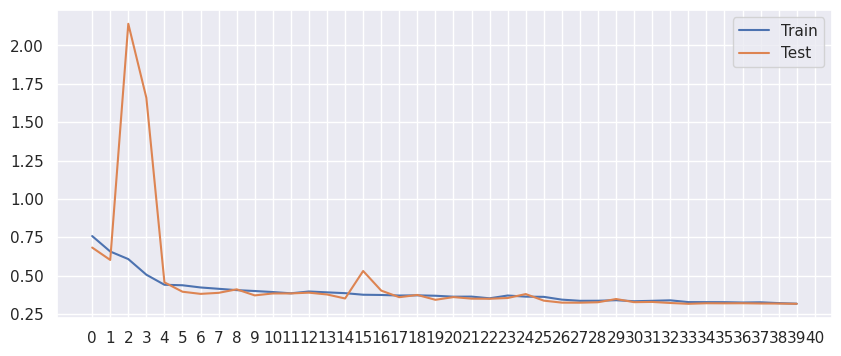

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(10, 4))
x = range(epochs)
sns.lineplot(x=x, y=hist[0], label='Train', ax=ax)
sns.lineplot(x=x, y=hist[1], label='Test', ax=ax)
plt.xticks(range(epochs+1))
plt.legend()
plt.show()

Epoch 20'st. Train Loss = 0.371257,  Validate Loss = 0.405934,  Lr = [0.000125] \\
Epoch 35'st. Train Loss = 0.330873,  Validate Loss = 0.364837,  Lr = [0.000125]
 \\
Epoch 35'st. Train Loss = 0.346733,  Validate Loss = 0.330329,  Lr = [0.000125]
 \\
Epoch 40'st. Train Loss = 0.317505,  Validate Loss = 0.316799,  Lr = [0.000125]
 \\
 Epoch 40'st. Train Loss = 0.318861, Validate Loss = 0.334935, IOU = 0.837286  Lr = [0.000125]

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    num =
    den =
    res =
    return res

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred =  # hint: torch.clamp
    return your_loss


In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
<TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

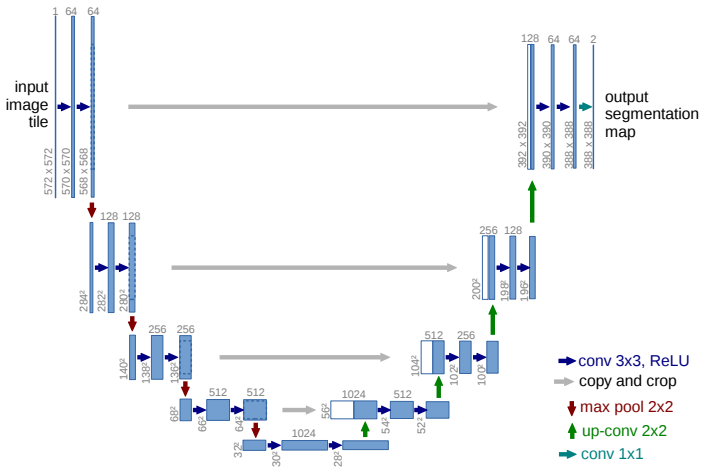

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
def double_conv(in_c: int, out_c: int):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down_conv_1 = double_conv(3, 64) # 64x128x128
        self.down_conv_2 = double_conv(64, 128) # 128x64x64
        self.down_conv_3 = double_conv(128, 256) # 256x32x32
        self.down_conv_4 = double_conv(256, 512) # 512x16x16

        self.bottleneck_conv = double_conv(512, 1024) # 1024x16x16

        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 512x32x32
        self.up_conv_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # 512x32x32
        self.norm_1 = nn.BatchNorm2d(512)

        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 256x64x64
        self.up_conv_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # 256x64x64
        self.norm_2 = nn.BatchNorm2d(256)

        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 128x128x128
        self.up_conv_3 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # 128x128x128
        self.norm_3 = nn.BatchNorm2d(128)

        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 64x256x256
        self.up_conv_4 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # 64x256x256
        self.norm_4 = nn.BatchNorm2d(64)

        self.output = nn.Conv2d(64, 1, kernel_size=1) # 1x256x256

    def forward(self, x):
        x1 = self.down_conv_1(x)
        x1_pool = self.max_pool(x1)
        x2 = self.down_conv_2(x1_pool)
        x2_pool = self.max_pool(x2)
        x3 = self.down_conv_3(x2_pool)
        x3_pool = self.max_pool(x3)
        x4 = self.down_conv_4(x3_pool)
        x4_pool = self.max_pool(x4)
        b = self.bottleneck_conv(x4_pool)

        x = self.up_trans_1(b) # 512x32x32
        x = self.up_conv_1(torch.cat([x, x4], dim=1)) # [512x32x32 <-> 512x32x32]
        x = self.norm_1(x)
        x = F.relu(x, inplace=True)

        x = self.up_trans_2(x) # 256x64x64
        x = self.up_conv_2(torch.cat([x, x3], dim=1)) # [256x64x64 <-> 256x64x64]
        x = self.norm_2(x)
        x = F.relu(x, inplace=True)

        x = self.up_trans_3(x) # 128x128x128
        x = self.up_conv_3(torch.cat([x, x2], dim=1)) # [128x128x128 <-> 128x128x128]
        x = self.norm_3(x)
        x = F.relu(x, inplace=True)

        x = self.up_trans_4(x) # 64x256x256
        x = self.up_conv_4(torch.cat([x, x1], dim=1)) # [64x256x256 <-> 64x256x256]
        x = self.norm_4(x)
        x = F.relu(x, inplace=True)

        x = self.output(x)
        return x

In [ ]:
model = UNet().to(device)

epochs = 40
loss_func = nn.BCELoss()
opt = optim.Adam(params=model.parameters(), lr=0.001)
scheduler = lr_scheduler.MultiStepLR(opt, milestones=[25, 30, 35], gamma=0.5)

hist = fit(model, opt, loss_func, epochs, train_loader, test_loader, scheduler)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1'st. Train Loss = 0.452933, Validate Loss = 0.621434, IOU = 0.0  Lr = [0.001]
Epoch 2'st. Train Loss = 0.321119, Validate Loss = 0.848047, IOU = 0.0  Lr = [0.001]
Epoch 3'st. Train Loss = 0.28934, Validate Loss = 0.481742, IOU = 0.17234  Lr = [0.001]
Epoch 4'st. Train Loss = 0.290549, Validate Loss = 0.404777, IOU = 0.329183  Lr = [0.001]
Epoch 5'st. Train Loss = 0.254924, Validate Loss = 0.88847, IOU = 0.176135  Lr = [0.001]
Epoch 6'st. Train Loss = 0.238514, Validate Loss = 0.334449, IOU = 0.497728  Lr = [0.001]
Epoch 7'st. Train Loss = 0.23011, Validate Loss = 0.378186, IOU = 0.439652  Lr = [0.001]
Epoch 8'st. Train Loss = 0.239163, Validate Loss = 0.237228, IOU = 0.734538  Lr = [0.001]
Epoch 9'st. Train Loss = 0.232158, Validate Loss = 0.236791, IOU = 0.69332  Lr = [0.001]
Epoch 10'st. Train Loss = 0.214511, Validate Loss = 0.211146, IOU = 0.756368  Lr = [0.001]
Epoch 11'st. Train Loss = 0.214847, Validate Loss = 0.246885, IOU = 0.777665  Lr = [0.001]
Epoch 12'st. Train Loss

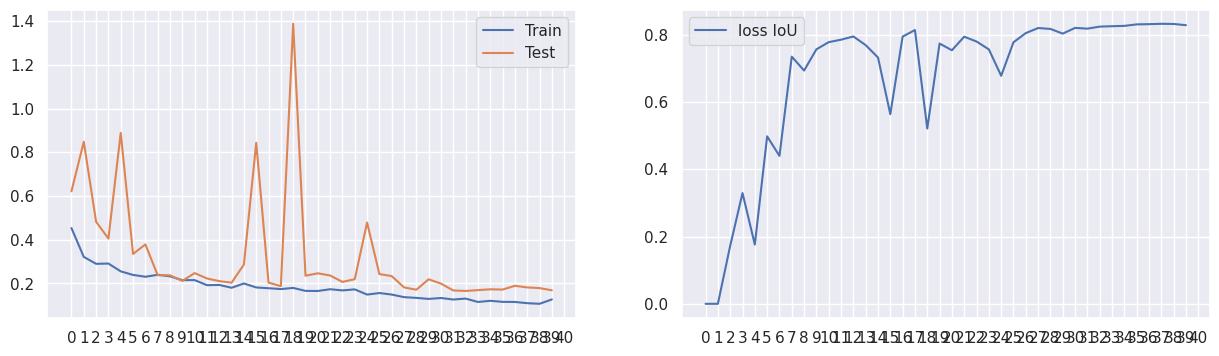

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
x = range(epochs)
sns.lineplot(x=x, y=hist[0], label='Train', ax=ax[0])
sns.lineplot(x=x, y=hist[1], label='Test', ax=ax[0])

sns.lineplot(x=x, y=hist[2], label='loss IoU', ax=ax[1])

ax[0].set_xticks(range(epochs+1))
ax[1].set_xticks(range(epochs+1))
plt.legend()
plt.show()

Epoch 40'st. Train Loss = 0.175154, Validate Loss = 0.237539, IOU = 0.773065  Lr = [0.000125]
 \\
Epoch 40'st. Train Loss = 0.126343, Validate Loss = 0.16822, IOU = 0.8281  Lr = [0.000125]

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):


In [ ]:
unet2_model = UNet2().to(device)


In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.